## Load cleaned Task 1 data

In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Dell\Pictures\playstore-fintech-cx\data\processed\playstore_reviews_clean.csv")
print(df.head())


                                              review  rating        date  \
0                   maaliif daddafee install gaafata       3  2025-11-28   
1                                           good app       5  2025-11-28   
2  This application is very important and advanta...       5  2025-11-27   
3                          why didn't work this app?       1  2025-11-27   
4      The app makes our life easier. Thank you CBE!       5  2025-11-27   

                                bank       source  
0  Commercial Bank of Ethiopia (CBE)  Google Play  
1  Commercial Bank of Ethiopia (CBE)  Google Play  
2  Commercial Bank of Ethiopia (CBE)  Google Play  
3  Commercial Bank of Ethiopia (CBE)  Google Play  
4  Commercial Bank of Ethiopia (CBE)  Google Play  


## Sentiment Analysis

### Transformers (DistilBERT SST-2)

In [2]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def get_sentiment(text):
    result = classifier(text[:512])[0]  # limit to 512 tokens
    label = result['label'].lower()
    score = result['score']
    return label, score

df[['sentiment_label','sentiment_score']] = df['review'].apply(lambda x: pd.Series(get_sentiment(x)))


c:\Users\Dell\Pictures\playstore-fintech-cx\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


### Simple with VADER

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return "positive", score
    elif score <= -0.05:
        return "negative", score
    else:
        return "neutral", score

df[['sentiment_label','sentiment_score']] = df['review'].apply(lambda x: pd.Series(get_sentiment(x)))


### Thematic Analysis

### Preprocess text

Tokenization, stop-word removal, lemmatization using spaCy:

In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in STOP_WORDS]
    return tokens

df['tokens'] = df['review'].apply(preprocess_text)

### Extract keywords

Use TF-IDF or simple frequency counts:

In [5]:
from collections import Counter

df['keywords'] = df['tokens'].apply(lambda x: [word for word, _ in Counter(x).most_common(5)])
print(df.head())

                                              review  rating        date  \
0                   maaliif daddafee install gaafata       3  2025-11-28   
1                                           good app       5  2025-11-28   
2  This application is very important and advanta...       5  2025-11-27   
3                          why didn't work this app?       1  2025-11-27   
4      The app makes our life easier. Thank you CBE!       5  2025-11-27   

                                bank       source sentiment_label  \
0  Commercial Bank of Ethiopia (CBE)  Google Play         neutral   
1  Commercial Bank of Ethiopia (CBE)  Google Play        positive   
2  Commercial Bank of Ethiopia (CBE)  Google Play        positive   
3  Commercial Bank of Ethiopia (CBE)  Google Play         neutral   
4  Commercial Bank of Ethiopia (CBE)  Google Play        positive   

   sentiment_score                                             tokens  \
0           0.0000              [maaliif, daddafee, ins

### Assign themes

Define a keyword-to-theme mapping:

In [6]:
THEME_KEYWORDS = {
    "UI & UX": ["interface", "UI", "navigation", "layout"],
    "Transaction Performance": ["transfer", "slow", "delay", "load"],
    "Login & Account Access": ["login", "password", "error", "OTP"],
    "Customer Support": ["support", "call", "help", "response"],
    "Feature Requests": ["feature", "fingerprint", "notification"]
}

def assign_theme(tokens):
    themes = set()
    for theme, keywords in THEME_KEYWORDS.items():
        if any(k in tokens for k in keywords):
            themes.add(theme)
    return list(themes) if themes else ["Other"]

df['themes'] = df['tokens'].apply(assign_theme)
print(df[['review', 'themes']].head())


                                              review  \
0                   maaliif daddafee install gaafata   
1                                           good app   
2  This application is very important and advanta...   
3                          why didn't work this app?   
4      The app makes our life easier. Thank you CBE!   

                      themes  
0                    [Other]  
1                    [Other]  
2  [Transaction Performance]  
3                    [Other]  
4                    [Other]  


### Aggregate results

Compute average sentiment per bank, per rating:

In [10]:
import os
print(os.getcwd())

c:\Users\Dell\Pictures\playstore-fintech-cx\notebooks


In [11]:
import os
os.chdir(r"C:\Users\Dell\Pictures\playstore-fintech-cx")
print(os.getcwd())


C:\Users\Dell\Pictures\playstore-fintech-cx


In [13]:
import sys
sys.path.append(r"C:\Users\Dell\Pictures\playstore-fintech-cx")

from src.analyze_sentiment import apply_sentiment
from src.thematic_utils import apply_themes


df = pd.read_csv(r"C:\Users\Dell\Pictures\playstore-fintech-cx\data\processed\playstore_reviews_clean.csv")

df = apply_sentiment(df)
df = apply_themes(df)

print(df[['review','sentiment_label','sentiment_score','themes']].head())

                                              review sentiment_label  \
0                   maaliif daddafee install gaafata         neutral   
1                                           good app        positive   
2  This application is very important and advanta...        positive   
3                          why didn't work this app?         neutral   
4      The app makes our life easier. Thank you CBE!         neutral   

   sentiment_score      themes  
0             0.00          []  
1             0.70          []  
2             0.52  [features]  
3             0.00          []  
4             0.00          []  


## Save final results

In [14]:
df.to_csv(r"C:\Users\Dell\Pictures\playstore-fintech-cx\data\processed\reviews_sentiment_themes.csv", index=False)

## Sentiment distribution per bank:

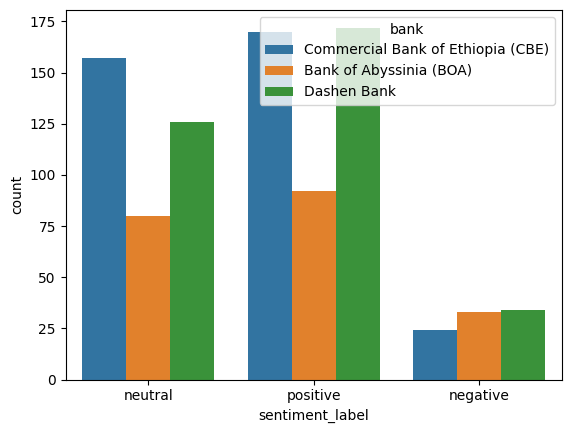

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='sentiment_label', hue='bank')
plt.show()


## Average Sentiment Score by Star Rating

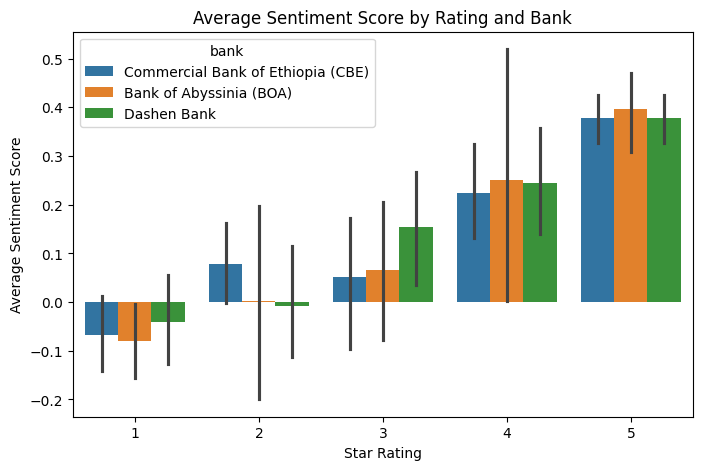

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(x="rating", y="sentiment_score", hue="bank", data=df)
plt.title("Average Sentiment Score by Rating and Bank")
plt.xlabel("Star Rating")
plt.ylabel("Average Sentiment Score")
plt.show()


## Top Keywords Word Cloud per BankTop Keywords Word Cloud per Bank

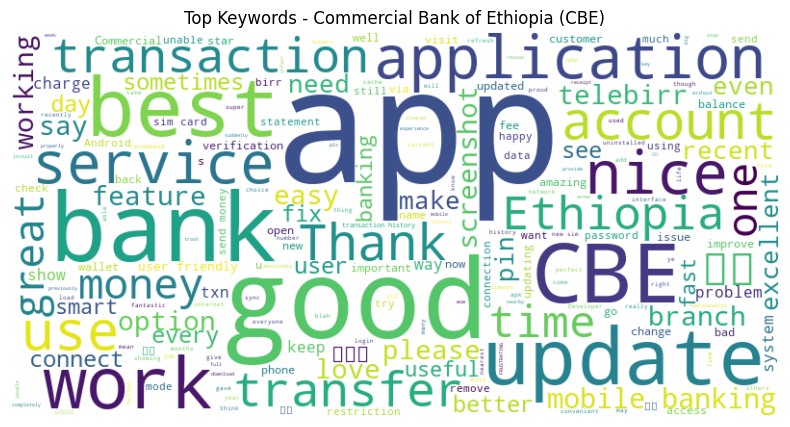

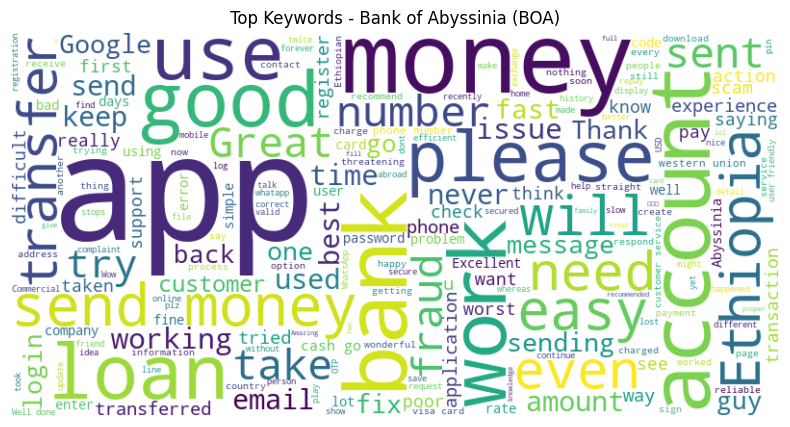

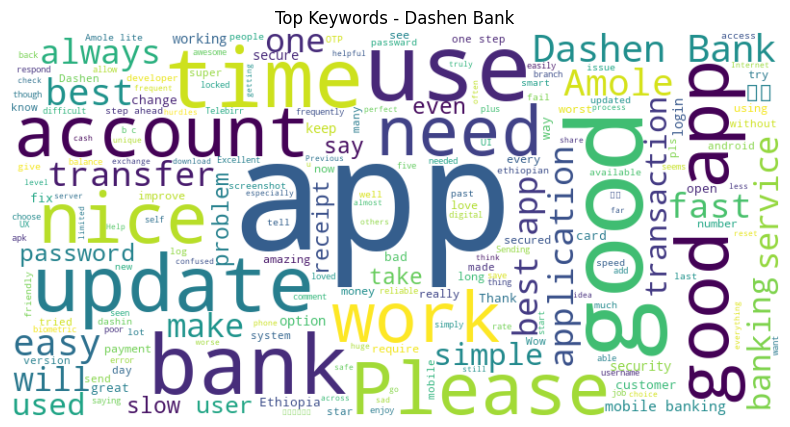

In [19]:
from wordcloud import WordCloud

for bank in df["bank"].unique():
    text = " ".join(df[df["bank"]==bank]["review"].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Top Keywords - {bank}")
    plt.show()


## Theme Distribution per Bank

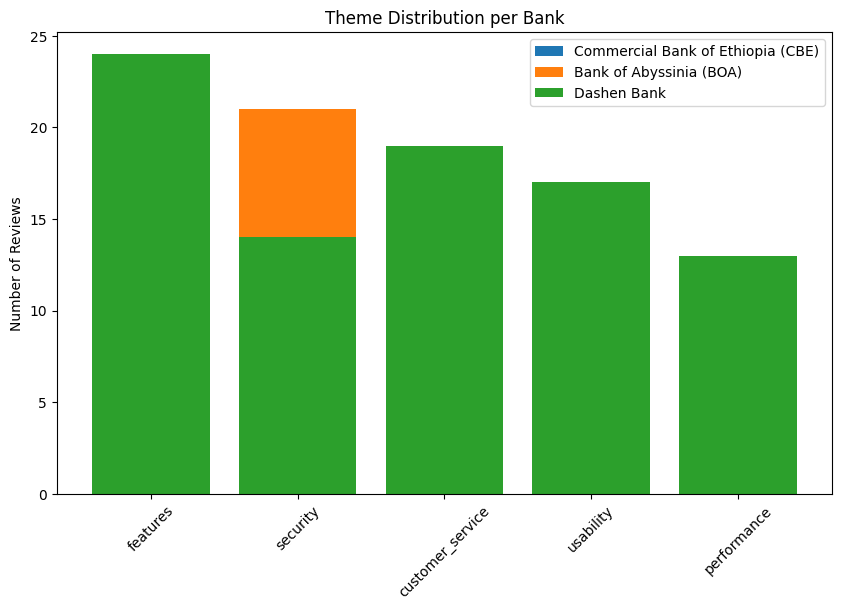

In [20]:
from collections import Counter
import ast

plt.figure(figsize=(10,6))
all_themes = []

for bank in df["bank"].unique():
    bank_df = df[df["bank"]==bank]
    # Convert stringified lists to Python list if needed
    bank_themes = bank_df["themes"].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)
    themes_flat = [theme for sublist in bank_themes for theme in sublist]
    all_themes.append((bank, Counter(themes_flat)))

for bank, counter in all_themes:
    plt.bar(counter.keys(), counter.values(), label=bank)

plt.title("Theme Distribution per Bank")
plt.xticks(rotation=45)
plt.ylabel("Number of Reviews")
plt.legend()
plt.show()


## Sentiment per Theme

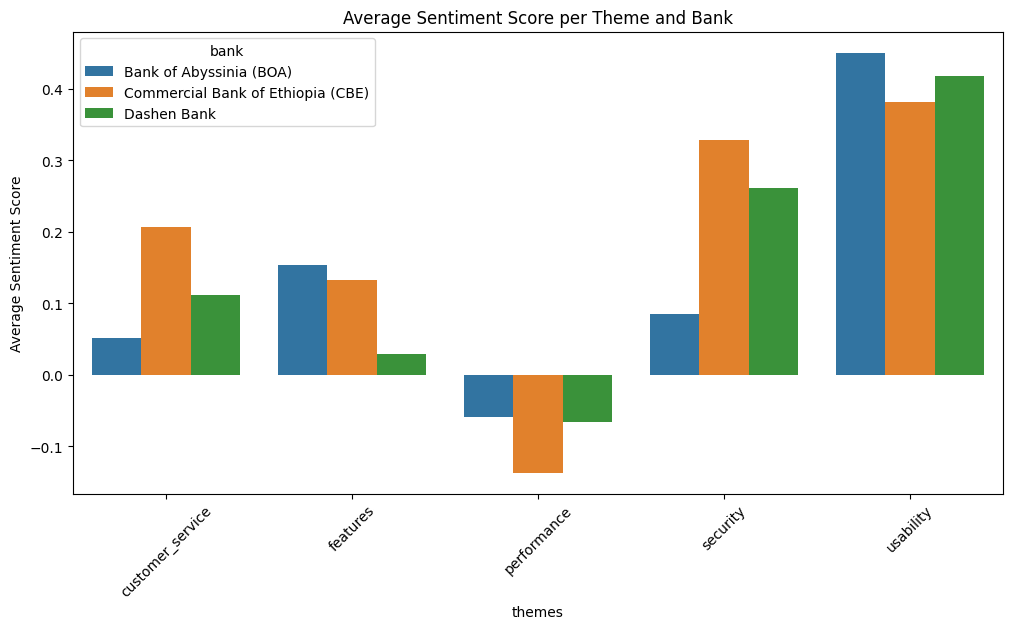

In [21]:
theme_sentiment = df.explode("themes").groupby(["themes","bank"])["sentiment_score"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x="themes", y="sentiment_score", hue="bank", data=theme_sentiment)
plt.title("Average Sentiment Score per Theme and Bank")
plt.xticks(rotation=45)
plt.ylabel("Average Sentiment Score")
plt.show()


## Heatmap for Theme vs Bank

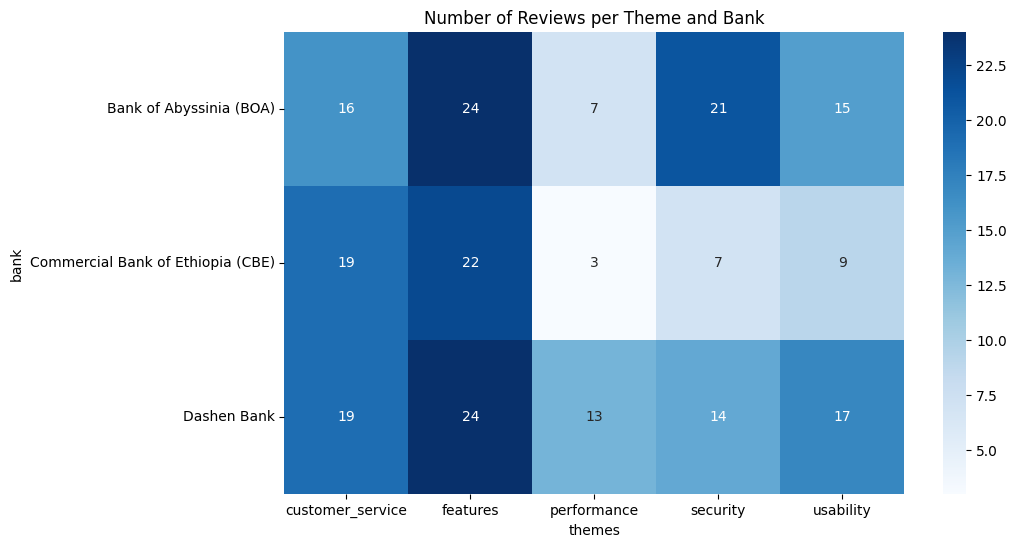

In [22]:
theme_counts = df.explode("themes").groupby(["bank","themes"]).size().unstack(fill_value=0)

plt.figure(figsize=(10,6))
sns.heatmap(theme_counts, annot=True, fmt="d", cmap="Blues")
plt.title("Number of Reviews per Theme and Bank")
plt.show()
